In [33]:
# Implement a simple Transformer model from scratch using PyTorch or TensorFlow.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attn = None

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = F.dropout(p_attn, p=0.1)
        self.attn = p_attn  # Save the attention weights

        x = torch.matmul(p_attn, value).transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        return self.linears[-1](x), p_attn  # Return the attention weights along with the output


In [43]:
# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [44]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)])

    def forward(self, x, mask):
        x = x + self.dropout[0](self.self_attn(self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), mask))
        x = x + self.dropout[1](self.feed_forward(self.sublayer[1](x)))
        return x

In [45]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(3)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = x + self.dropout[0](self.self_attn(self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), tgt_mask))
        x = x + self.dropout[1](self.cross_attn(self.sublayer[1](x), self.sublayer[1](memory), self.sublayer[1](memory), src_mask))
        x = x + self.dropout[2](self.feed_forward(self.sublayer[2](x)))
        return x

In [46]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder_embed = nn.Embedding(src_vocab, d_model)
        self.decoder_embed = nn.Embedding(tgt_vocab, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_encoder_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_decoder_layers)])
        self.output_linear = nn.Linear(d_model, tgt_vocab)
        self.dropout = nn.Dropout(dropout)

        # Store attention weights
        self.encoder_attn_weights = []
        self.decoder_attn_weights = []

    def encode(self, src, src_mask):
        x = self.dropout(self.positional_encoding(self.encoder_embed(src)))
        for layer in self.encoder_layers:
            x, attn_weights = layer.self_attn(x, x, x, src_mask)
            self.encoder_attn_weights.append(attn_weights)
            x = layer.feed_forward(x)
        return x

    def decode(self, tgt, memory, src_mask, tgt_mask):
        x = self.dropout(self.positional_encoding(self.decoder_embed(tgt)))
        for layer in self.decoder_layers:
            x, self_attn_weights = layer.self_attn(x, x, x, tgt_mask)
            self.decoder_attn_weights.append(self_attn_weights)
            x, cross_attn_weights = layer.cross_attn(x, memory, memory, src_mask)
            self.decoder_attn_weights.append(cross_attn_weights)
            x = layer.feed_forward(x)
        return x

    def forward(self, src, tgt, src_mask, tgt_mask):
        self.encoder_attn_weights = []
        self.decoder_attn_weights = []
        memory = self.encode(src, src_mask)
        output = self.decode(tgt, memory, src_mask, tgt_mask)
        return self.output_linear(output)


In [47]:
# Example usage
src_vocab_size = 10000
tgt_vocab_size = 10000
model = Transformer(src_vocab_size, tgt_vocab_size)

# Dummy input data
src = torch.randint(0, src_vocab_size, (10, 32))  # (sequence_length, batch_size)
tgt = torch.randint(0, tgt_vocab_size, (20, 32))  # (sequence_length, batch_size)
src_mask = tgt_mask = None  # No masks for simplicity

# Forward pass
output = model(src, tgt, src_mask, tgt_mask)

# Extract attention weights
encoder_attn_weights = model.encoder_attn_weights
decoder_attn_weights = model.decoder_attn_weights

print("Encoder attention weights shape:", [w.shape for w in encoder_attn_weights])
print("Decoder attention weights shape:", [w.shape for w in decoder_attn_weights])


Encoder attention weights shape: [torch.Size([10, 8, 32, 32]), torch.Size([10, 8, 32, 32]), torch.Size([10, 8, 32, 32]), torch.Size([10, 8, 32, 32]), torch.Size([10, 8, 32, 32]), torch.Size([10, 8, 32, 32])]
Decoder attention weights shape: [torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16]), torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16]), torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16]), torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16]), torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16]), torch.Size([20, 8, 32, 32]), torch.Size([20, 8, 32, 16])]


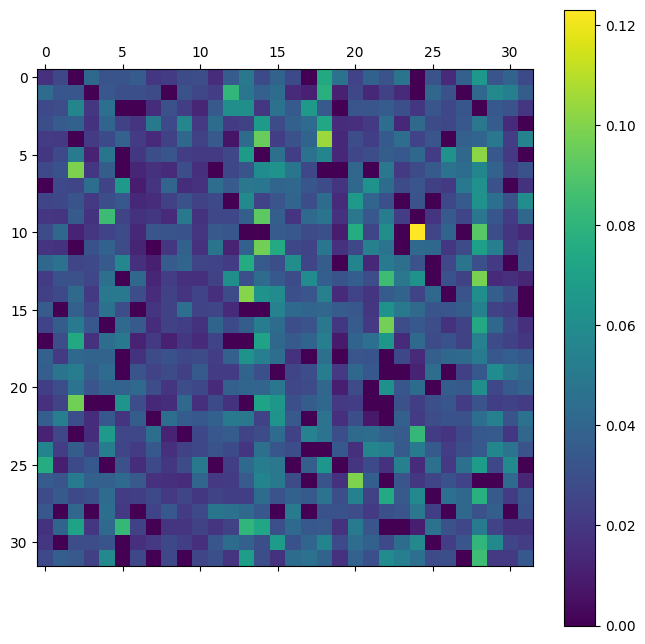

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize attention weights
def visualize_attention(attn_weights, layer_num=0, head_num=0, src_tokens=None, tgt_tokens=None):
    attn = attn_weights[layer_num][0, head_num].detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(attn, cmap='viridis')

    # Set up axes
    if src_tokens:
        ax.set_xticklabels([''] + src_tokens, rotation=90)
    if tgt_tokens:
        ax.set_yticklabels([''] + tgt_tokens)

    # Show color bar
    fig.colorbar(cax)
    plt.show()

# Example: Visualize the first attention head of the first encoder layer
visualize_attention(encoder_attn_weights, layer_num=0, head_num=0)


C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90)
C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + tgt_tokens)


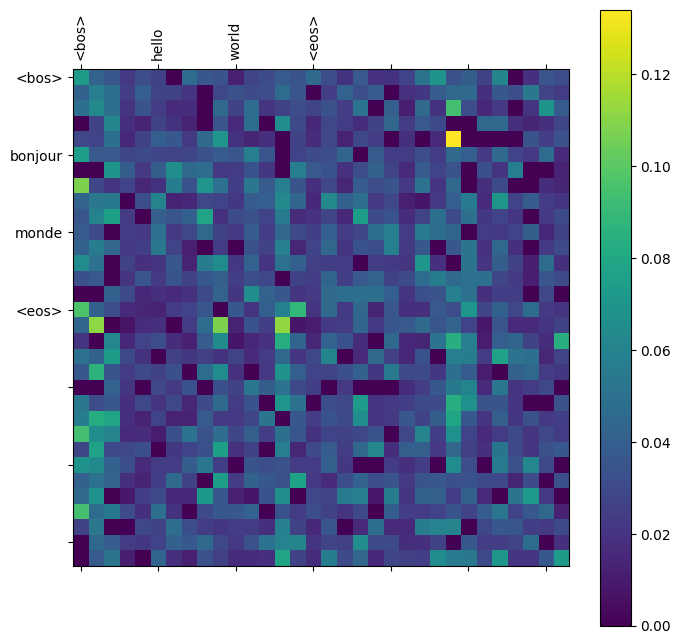

C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90)
C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + tgt_tokens)


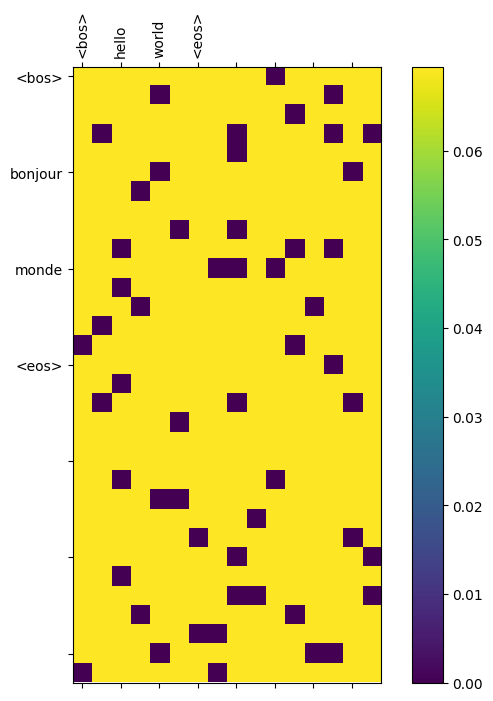

C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90)
C:\Users\manka\AppData\Local\Temp\ipykernel_9572\4223630097.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + tgt_tokens)


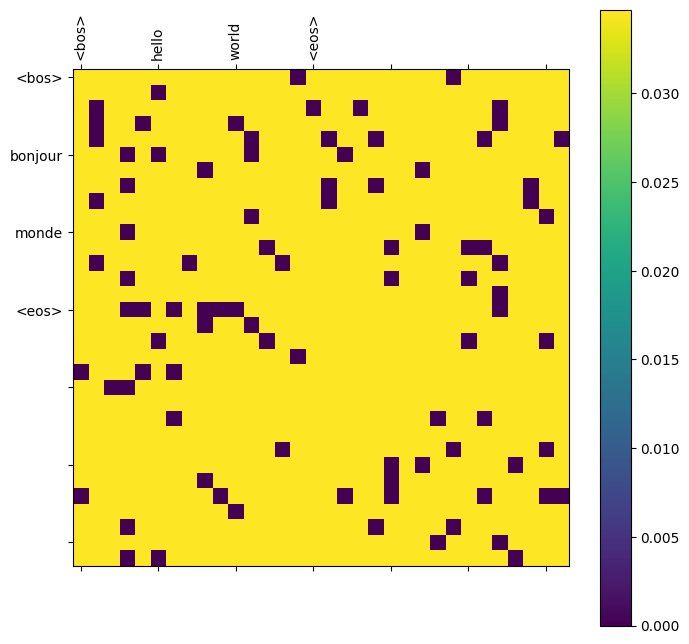

In [51]:

# Example: Visualize the first attention head of the first decoder layer
visualize_attention(decoder_attn_weights, layer_num=0, head_num=0, src_tokens=["<bos>"] + ["hello", "world", "<eos>"], tgt_tokens=["<bos>"] + ["bonjour", "monde", "<eos>"])

# Example: Visualize the second attention head of the second decoder layer
visualize_attention(decoder_attn_weights, layer_num=1, head_num=1, src_tokens=["<bos>"] + ["hello", "world", "<eos>"], tgt_tokens=["<bos>"] + ["bonjour", "monde", "<eos>"])

# Example: Visualize the third attention head of the third decoder layer
visualize_attention(decoder_attn_weights, layer_num=2, head_num=2, src_tokens=["<bos>"] + ["hello", "world", "<eos>"], tgt_tokens=["<bos>"] + ["bonjour", "monde", "<eos>"])
